<a href="https://colab.research.google.com/github/YuliannaG/DataScienceHW6/blob/main/HW6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Task 1

In [3]:
pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 5.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.6 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.1-py2.py3-none-any.whl size=281845512 sha256=537754597af4c3bb404c7820d6c3ccf8ed26f43798a19396375f294e7c8a0b2e
  Stored in directory: /root/.cache/pip/wheels/43/dc/11/ec201cd671da62fa9c5cc77078235e40722170ceba231d7598
Successfully built pyspark


In [4]:
import pandas as pd
import pyspark
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from pyspark.sql import Row
from pyspark.sql import SparkSession


spark_session = SparkSession.builder.appName("books").getOrCreate()

path = "/content/drive/MyDrive/books.csv"

rdd = spark_session.read.csv(path).rdd
#rdd = spark.read.option("header",'True').csv(path).rdd

print("The data has {} columns".format(len(rdd.first())))

header = rdd.first()
print(header)

The data has 7 columns
Row(_c0='Name', _c1='Author', _c2='User Rating', _c3='Reviews', _c4='Price', _c5='Year', _c6='Genre')


Используя только RDD вычислить среднюю цену всех книг, у которых рейтинг выше 4.7

In [7]:
#https://datascienceplus.com/dataframes-vs-rdds-in-spark-part-1/

content = rdd.filter(lambda line: line != header)

prices = content.filter(lambda line: line[2] > '4.7').map(lambda line:float(line[4])).collect()
avg_price = np.mean(prices)
print(f'Average price of books with raiting > 4.7 is {avg_price}')

Average price of books with raiting > 4.7 is 10.69832402234637


Построить гистограмму распределения рецензий (столбец Reviews).

([0, 10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000], [325, 119, 79, 11, 4, 7, 2, 2, 1])
([37.0, 8817.4, 17597.8, 26378.199999999997, 35158.6, 43939.0, 52719.399999999994, 61499.799999999996, 70280.2, 79060.59999999999, 87841.0], [287, 131, 87, 25, 4, 8, 5, 0, 0, 3])


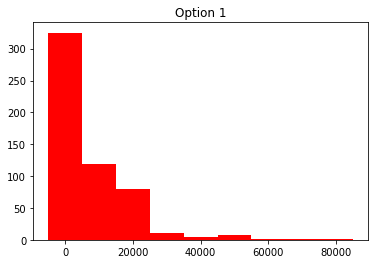

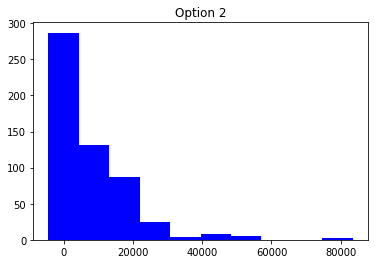

In [8]:
#https://spark.apache.org/docs/latest/api/python/reference/api/pyspark.RDD.histogram.html

reviews = content.map(lambda line:float(line[3]))

hist1 = reviews.histogram([0,10000, 20000, 30000, 40000, 50000, 60000, 70000, 80000, 90000])
print(hist1)

hist2 = reviews.histogram(10)
print(hist2)


fig1 = plt.figure("Option 1")
heights1 = np.array(hist1[1])
full_bins1 = hist1[0]
mid_point_bins1 = full_bins1[:-1]
widths1 = [abs(i - j) for i, j in zip(full_bins1[:-1], full_bins1[1:])]
plt.bar(mid_point_bins1, heights1, width=widths1, color='r')
plt.title("Option 1")

plt.show()

fig2 = plt.figure("Option 1")
heights2 = np.array(hist2[1])
full_bins2 = hist2[0]
mid_point_bins2 = full_bins2[:-1]
widths2 = [abs(i - j) for i, j in zip(full_bins2[:-1], full_bins2[1:])]
plt.bar(mid_point_bins2, heights2, width=widths2, color='b')
plt.title("Option 2")

plt.show()

Построить матрицу корреляции для столбцов "User Rating", "Reviews" и "Price".

In [58]:
#from pyspark.mllib.stat import Statistics

# rating = content.map(lambda line:float(line[2]))
# reviews = content.map(lambda line:float(line[3]))
# price = content.map(lambda line:float(line[4]))
# Statistics.corr(rating, reviews, method = 'pearson')
# CANNOT MAKE THE MATRIXS WITH CORRELATION OF ALL 3 PARAMETERS

df = spark_session.read.option("header",'True').csv(path)
df_cut = df['User rating', 'Reviews', 'Price'].toPandas().astype(float)
print('Correlation matrix\n',df_cut.corr(method = "pearson"))


Correlation matrix
              User rating   Reviews     Price
User rating     1.000000 -0.001729 -0.133086
Reviews        -0.001729  1.000000 -0.109182
Price          -0.133086 -0.109182  1.000000


Используя библиотеку seaborn построить парные графики (pairplots) столбцов "User Rating", "Reviews" и "Price".

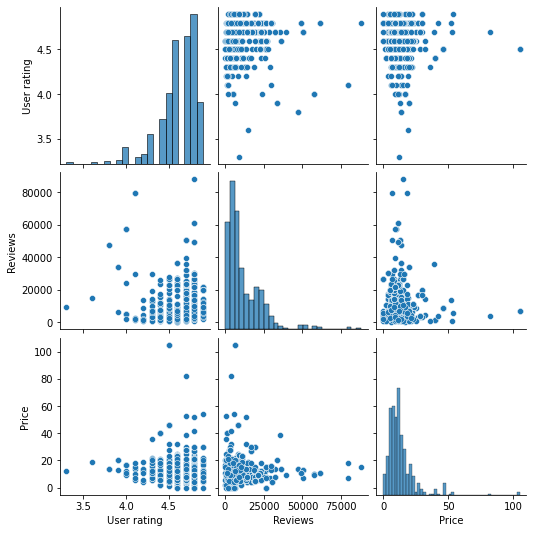

In [6]:
df_cut2 = df['User rating', 'Reviews', 'Price'].toPandas().astype(float)
sns.pairplot(df_cut2)

# Task 2

При выполнении этого задания разрешается использовать только Spark SQL. Для датасета из предыдущего задания выполните следующее:

Найдите автора с самым высоким рейтингом.

In [67]:
import pyspark.sql.functions as F

df.createOrReplaceTempView("books")
spark_session.sql("Select Author, avg(`User Rating`) From books Group By Author Order by avg(`User Rating`) DESC Limit 1").show()

+----------+----------------+
|    Author|avg(User Rating)|
+----------+----------------+
|Jill Twiss|             4.9|
+----------+----------------+



Найдите трех авторов с самым низким рейтингом.

In [68]:
spark_session.sql("Select Author, avg(`User Rating`) From books Group By Author Order by avg(`User Rating`) ASC Limit 3").show()

+--------------+----------------+
|        Author|avg(User Rating)|
+--------------+----------------+
|   Donna Tartt|             3.9|
| Gillian Flynn|             4.0|
|Muriel Barbery|             4.0|
+--------------+----------------+



Определите какой автор получил наибольшее количество рецензий.

In [72]:
spark_session.sql("Select Author, sum(Reviews) From books Group By Author Order by sum(Reviews) DESC Limit 1").show()

+---------------+------------+
|         Author|sum(Reviews)|
+---------------+------------+
|Suzanne Collins|    278329.0|
+---------------+------------+



Определите какой автор написал наибольшее количество книг за весь доступный в данных период.

In [75]:
spark_session.sql("Select Author, count(Name) From books Group By Author Order by count(Name) DESC Limit 1").show()

+-----------+-----------+
|     Author|count(Name)|
+-----------+-----------+
|Jeff Kinney|         12|
+-----------+-----------+



Определите какая книга жанра "Fiction" имеет самый маленький рейтинг

In [91]:
spark_session.sql("Select Name, `User Rating`, Genre From books Where Genre = 'Fiction' Order by `User Rating` ASC Limit 1 ").show()

+------------------+-----------+-------+
|              Name|User Rating|  Genre|
+------------------+-----------+-------+
|The Casual Vacancy|        3.3|Fiction|
+------------------+-----------+-------+



Определите какая книга жанра "Non Fiction" имеет самый высокий рейтинг.

In [94]:
spark_session.sql("Select Name, `User Rating`, Genre From books Where Genre = 'Non Fiction' Order by `User Rating` DESC Limit 1 ").show()

+--------------------+-----------+-----------+
|                Name|User Rating|      Genre|
+--------------------+-----------+-----------+
|Hamilton: The Rev...|        4.9|Non Fiction|
+--------------------+-----------+-----------+



# Task 3

Постройте гистограмму среднего количества рецензий по годам. В виде отдельной гистограммы визуализируйте количество книг жанра "Fiction" и "Non Fiction" за весь доступный период.

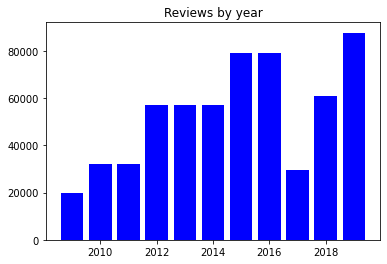

In [100]:
df_reviews = df['Reviews', 'Year'].toPandas().astype(float)

fig1 = plt.figure()
reviews = np.array(df_reviews['Reviews'])
years = np.array(df_reviews['Year'])
plt.bar(years, reviews, color='b')
plt.title("Reviews by year")

plt.show()

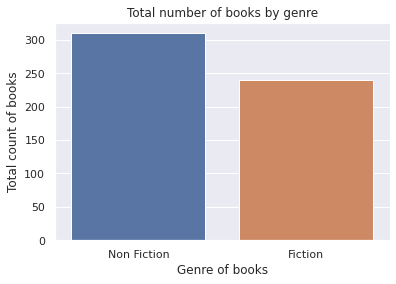

In [128]:
df_genres = df['Name', 'Genre'].toPandas()
ax = sns.countplot(x="Genre", data=df_genres)
ax.set(title = "Total number of books by genre")
ax.set_xlabel("Genre of books")
ax.set_ylabel("Total count of books")

plt.show()